# Dataless Neural Network for MIS finding in Graphs

## 1. Generate a random dense graph using NetworkX
This will be the graph that we find the MIS of

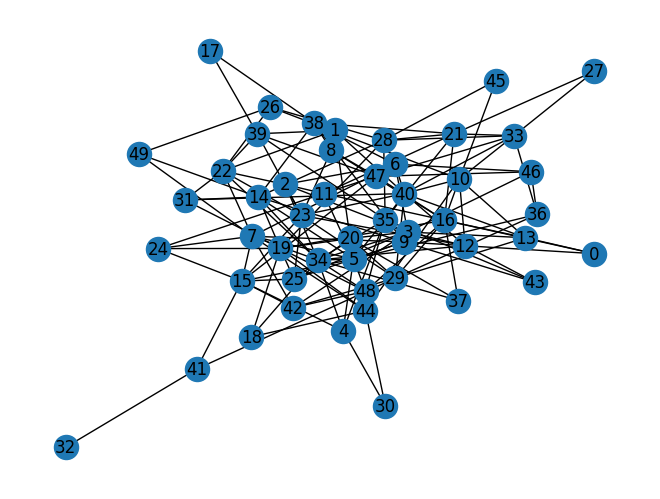

In [1]:
import networkx as nx

NUMBER_OF_NODES = 50
NUMBER_OF_EDGES = 150
SEED = 13

G = nx.generators.dense_gnm_random_graph(NUMBER_OF_NODES, NUMBER_OF_EDGES, seed=SEED)

nx.draw(G,with_labels=True)

## 2. Generate a neural network to solve your graph's MIS

### Perform an optimization using the structure and weights to determine the MIS

training_step = 0 --- value = 283.6560 --- desired value set for optimization = -inf
training_step = 1 --- value = 252.4514 --- desired value set for optimization = -inf
training_step = 2 --- value = 226.1859 --- desired value set for optimization = -inf
training_step = 3 --- value = 201.0280 --- desired value set for optimization = -inf
training_step = 4 --- value = 175.9124 --- desired value set for optimization = -inf
training_step = 5 --- value = 152.4940 --- desired value set for optimization = -inf
training_step = 6 --- value = 130.8017 --- desired value set for optimization = -inf
training_step = 7 --- value = 112.5376 --- desired value set for optimization = -inf
training_step = 8 --- value = 98.1374 --- desired value set for optimization = -inf
training_step = 9 --- value = 84.6927 --- desired value set for optimization = -inf
training_step = 10 --- value = 71.6334 --- desired value set for optimization = -inf
training_step = 11 --- value = 59.6936 --- desired value set for op

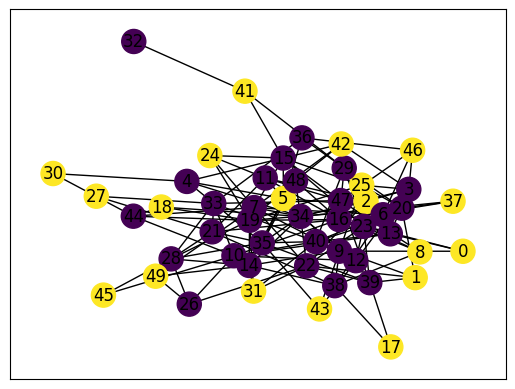

In [2]:
import torch
import numpy
import time
from datalessNN import datalessNN_graph_params, datalessNN_module
from layer_constraints import ZeroOneClamp

initial_learning_rate = 0.01
training_steps = 3500

## generate graph weights
NN_graph_params = datalessNN_graph_params(G)

graph_order = len(G.nodes)

NN = datalessNN_module(
    NN_graph_params["theta_tensor"],
    NN_graph_params["layer_2_weights"],
    NN_graph_params["layer_2_biases"],
    NN_graph_params["layer_3_weights"])

################# optimization
# good and fast results on most is found at initial_learning_rate = 0.001
optimizer = torch.optim.Adam(NN.parameters(), lr=initial_learning_rate)
loss_target = torch.Tensor([float('-inf')])
theta_constraint = ZeroOneClamp()

################################################################
##### X_train is the same for both gen and combined models #####
################################################################

X_train = numpy.ones(len(NN_graph_params["theta_tensor"]))

################################################################
### train
################################################################
X_star = None

start = time.time()
for i in range(training_steps):
    predicted_y = NN(X_train)

    optimizer.zero_grad()
    loss = (predicted_y - loss_target)
    loss.backward()
    optimizer.step()

    ## normalize theta values between 0 and 1
    NN[0].apply(theta_constraint)

    X_star = NN[0].weight

    if any(X_star > 1.0) or any(X_star < 0.0):
        print(f"exit AT training step = {i} --- THERE IS A A VALUE IN THE WEIGHTS OUTSIDE [0,1] --- x_star = {X_star}")
        break

    print(f"training_step = {i} --- value = {predicted_y.item():.4f} --- desired value set for optimization = {loss_target[0]}")

x_star = X_star.detach().numpy()

greater_than_09 = (x_star > 0.9).sum()
print(f"Size of MIS (theta > 0.9): {greater_than_09}")
nx.draw_networkx(G, node_color=x_star)